# Project 3 Qianchen Yu


In [1]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc,
    classification_report,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay,
)

from scipy.stats import loguniform
from xgboost import XGBClassifier

sns.set_theme(style="whitegrid")
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
DATA_PATH = Path("new_train_EGN5442.csv")


## Load data

In [2]:
df_raw = pd.read_csv(DATA_PATH)
print(df_raw.head())


   Unnamed: 0  y      x2      x3  x5  x9  x10  x11  x12  x13  ... x23   x24  \
0           0  1  #54359  Female  50   5    5    5    4    3  ...  21  12.0   
1           1  1  #84649  Female  44   1    1    1    1    3  ...   0   0.0   
2           2  0  #59015  Female  72   3    1    5    5    3  ...   0   8.0   
3           3  0  #99990  Female  38   1    3    1    3    5  ...   0   0.0   
4           4  1  #83569    Male  37   5    5    5    5    2  ...   0   0.0   

   x25  x26  x28       x29  x30       x31  x4  x6  
0  D_C   Bt    1   (192&&)  NaN  2.380952   4  50  
1  L_C   Bt    1  (1034&&)  NaN       inf   4  44  
2  L_C   Bt    3  (1452&&)  NaN       inf   4  72  
3  L_C   PT    3   (916&&)  NaN       inf   4  38  
4  L_C   Bt    1   (390&&)  NaN       inf   4  37  

[5 rows x 29 columns]


## Defining functions

In [3]:
def plot_target_distribution(df):
    fig, ax = plt.subplots(figsize=(4, 4))
    df["y"].value_counts().sort_index().plot(
        kind="bar", ax=ax, color=["#4c72b0", "#dd8452"]
    )
    ax.set_xlabel("y")
    ax.set_ylabel("count")
    ax.set_title("Target distribution")
    for p in ax.patches:
        ax.annotate(f"{int(p.get_height())}", (p.get_x() + 0.1, p.get_height() + 500))
    plt.tight_layout()


def plot_missingness(df, top_n=15):
    missing = df.isna().mean().sort_values(ascending=False)
    missing = missing[missing > 0].head(top_n)
    if missing.empty:
        print("No missing values.")
        return
    ax = (missing * 100).plot.bar(figsize=(8, 4), color="#4c72b0")
    ax.set_ylabel("Missing (%)")
    ax.set_title(f"Top {len(missing)} features by missingness")
    plt.tight_layout()


## Data cleaning

In [4]:
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    # Light cleaning: strip strings, parse numeric-like text, drop obvious junk.
    clean = df.copy()

    if "Unnamed: 0" in clean.columns:
        clean = clean.rename(columns={"Unnamed: 0": "row_id"})
        clean = clean.drop(columns=["row_id"])

    # Normalize text columns
    for col in clean.select_dtypes(include="object").columns:
        clean[col] = clean[col].astype(str).str.strip()

    # Parse numeric-like strings
    if "x2" in clean.columns:
        clean["x2"] = pd.to_numeric(clean["x2"].str.replace("#", "", regex=False), errors="coerce")
    if "x29" in clean.columns:
        clean["x29"] = pd.to_numeric(clean["x29"].str.extract(r"(-?\\d+\\.?\\d*)")[0], errors="coerce")
    if "x14" in clean.columns:
        clean["x14"] = pd.to_numeric(clean["x14"], errors="coerce")

    # Drop columns that are fully missing
    if "x30" in clean.columns and clean["x30"].isna().mean() >= 0.999:
        clean = clean.drop(columns=["x30"])
    elif "x30" in clean.columns:
        clean["x30"] = pd.to_numeric(clean["x30"], errors="coerce")

    clean.replace([np.inf, -np.inf], np.nan, inplace=True)
    return clean


In [5]:
df = clean_dataframe(df_raw)
display(df.head())




,y,x2,x3,x5,x9,x10,x11,x12,x13,x14,...,x22,x23,x24,x25,x26,x28,x29,x31,x4,x6
0,1,54359,Female,50,5,5,5,4,3,5.0,...,3,21,12.0,D_C,Bt,1,NaN,2.380952,4,50
1,1,84649,Female,44,1,1,1,1,3,3.0,...,2,0,0.0,L_C,Bt,1,NaN,NaN,4,44
2,0,59015,Female,72,3,1,5,5,3,2.0,...,2,0,8.0,L_C,Bt,3,NaN,NaN,4,72
3,0,99990,Female,38,1,3,1,3,5,1.0,...,5,0,0.0,L_C,PT,3,NaN,NaN,4,38
4,1,83569,Male,37,5,5,5,5,2,5.0,...,5,0,0.0,L_C,Bt,1,NaN,NaN,4,37


## Explortatory analysis

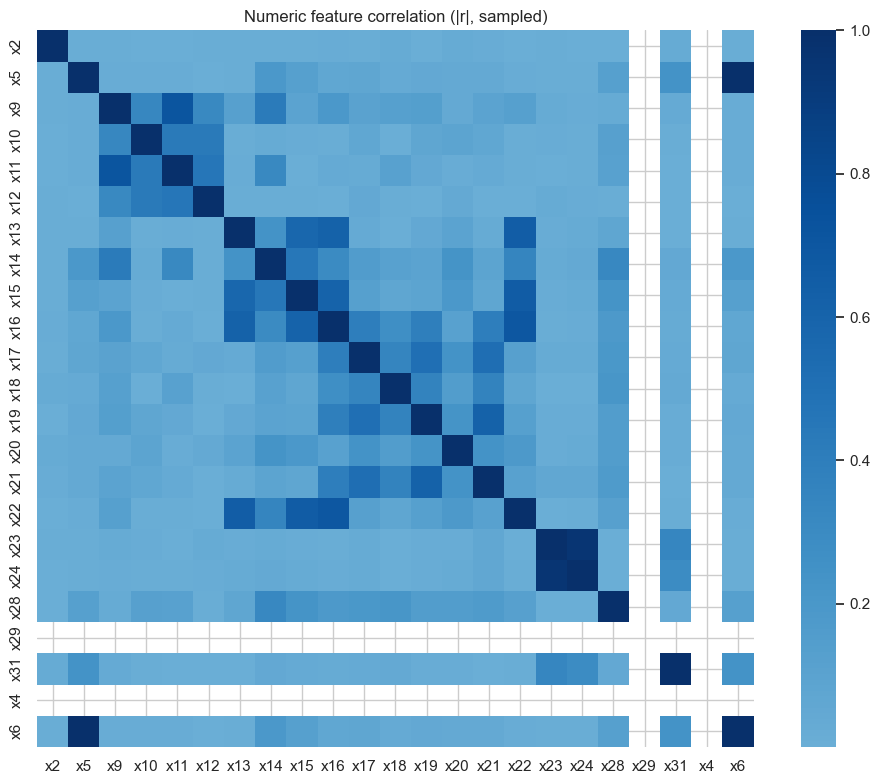

In [6]:
numeric_cols_preview = df.drop(columns=["y"]).select_dtypes(exclude="object").columns
sample = df.sample(n=min(len(df), 5000), random_state=RANDOM_STATE)
corr = sample[numeric_cols_preview].corr().abs()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="Blues", center=0, square=True)
plt.title("Numeric feature correlation (|r|, sampled)")
plt.tight_layout()


## Split data & build preprocessors

In [7]:
target = "y"
feature_cols = [c for c in df.columns if c != target]

train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df[target], random_state=RANDOM_STATE
)
train_df, val_df = train_test_split(
    train_df, test_size=0.2, stratify=train_df[target], random_state=RANDOM_STATE
)

X_train, y_train = train_df[feature_cols], train_df[target]
X_val, y_val = val_df[feature_cols], val_df[target]
X_test, y_test = test_df[feature_cols], test_df[target]

categorical_cols = X_train.select_dtypes(include="object").columns.tolist()
numeric_cols = X_train.select_dtypes(exclude="object").columns.tolist()
print("Categorical features:", categorical_cols)
print("Numeric features:", numeric_cols)


Categorical features: ['x3', 'x25', 'x26']
Numeric features: ['x2', 'x5', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x28', 'x29', 'x31', 'x4', 'x6']


In [8]:
def make_preprocessor(cat_cols, num_cols, scale_numeric=True):
    numeric_steps = [("imputer", SimpleImputer(strategy="median"))]
    if scale_numeric:
        numeric_steps.append(("scaler", StandardScaler()))
    numeric_transformer = Pipeline(numeric_steps)

    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    return ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_cols),
            ("cat", categorical_transformer, cat_cols),
        ],
        remainder="drop",
    )


linear_preprocess = make_preprocessor(categorical_cols, numeric_cols, scale_numeric=True)
tree_preprocess = make_preprocessor(categorical_cols, numeric_cols, scale_numeric=False)


In [9]:
def auc_score(model, X, y):
    probs = model.predict_proba(X)[:, 1]
    return roc_auc_score(y, probs)


def evaluate_pipeline(model, X_sets):
    return {name: auc_score(model, X, y) for name, (X, y) in X_sets.items()}


def plot_roc_curves(model, X_sets, title="ROC"):
    fig, ax = plt.subplots(figsize=(6, 5))
    for name, (X, y) in X_sets.items():
        RocCurveDisplay.from_estimator(model, X, y, ax=ax, name=name)
    ax.plot([0, 1], [0, 1], "k--", linewidth=1)
    ax.set_title(title)
    plt.tight_layout()


def get_feature_names(preprocessor, cat_cols, num_cols):
    feature_names = []
    for name, transformer, cols in preprocessor.transformers_:
        if name == "num":
            feature_names.extend(list(cols))
        elif name == "cat":
            ohe = transformer.named_steps["onehot"]
            feature_names.extend(ohe.get_feature_names_out(cols))
    return feature_names


## Part A — Logistic regression

{'train': 0.9422278180943217, 'val': 0.941711743954962, 'test': 0.9425339743705907}


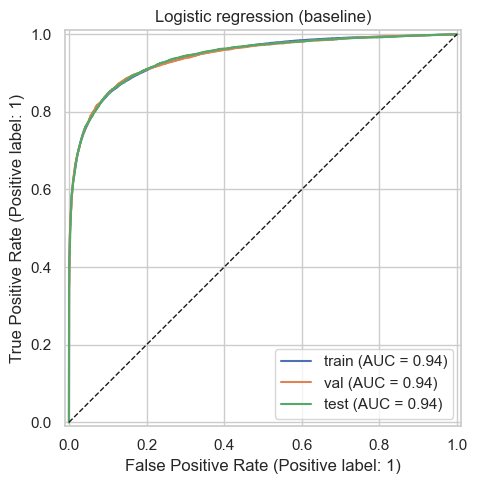

In [10]:
log_reg_baseline = Pipeline(
    steps=[
        ("preprocess", linear_preprocess),
        (
            "clf",
            LogisticRegression(
                max_iter=600,
                n_jobs=-1,
                penalty="l2",
                class_weight="balanced",
                solver="lbfgs",
            ),
        ),
    ]
)

log_reg_baseline.fit(X_train, y_train)

log_baseline_metrics = evaluate_pipeline(
    log_reg_baseline,
    {
        "train": (X_train, y_train),
        "val": (X_val, y_val),
        "test": (X_test, y_test),
    },
)
print(log_baseline_metrics)
plot_roc_curves(
    log_reg_baseline,
    {"train": (X_train, y_train), "val": (X_val, y_val), "test": (X_test, y_test)},
    title="Logistic regression (baseline)",
)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/qianchenyu/miniconda3/envs/urbanai/lib/python3.11/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['x29']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/qianchenyu/miniconda3/envs/urbanai/lib/python3.11/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['x29']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/qianchenyu/miniconda3/envs/urbanai/lib/python3.11/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['x29']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/qianchenyu/miniconda3/envs/urbanai/lib/python3.11/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['x29']. At least one non-missing value is

Best params: {'clf__C': 4.5705630998014515, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1'}
{'train': 0.9422278997782887, 'val': 0.9417120634048856, 'test': 0.9425349966103459}


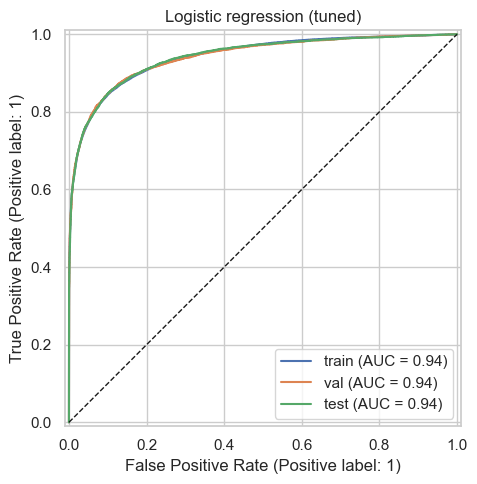

In [11]:
log_reg_tunable = Pipeline(
    steps=[
        ("preprocess", linear_preprocess),
        (
            "clf",
            LogisticRegression(
                max_iter=800,
                n_jobs=-1,
                solver="saga",
                penalty="l2",
                class_weight="balanced",
            ),
        ),
    ]
)

search_space = {
    "clf__penalty": ["l1", "l2"],
    "clf__C": loguniform(1e-3, 1e2),
    "clf__class_weight": ["balanced", None],
}

log_reg_search = RandomizedSearchCV(
    estimator=log_reg_tunable,
    param_distributions=search_space,
    n_iter=12,
    scoring="roc_auc",
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1,
    verbose=1,
    refit=True,
    random_state=RANDOM_STATE,
)

log_reg_search.fit(X_train, y_train)
print("Best params:", log_reg_search.best_params_)
log_tuned_metrics = evaluate_pipeline(
    log_reg_search.best_estimator_,
    {
        "train": (X_train, y_train),
        "val": (X_val, y_val),
        "test": (X_test, y_test),
    },
)
print(log_tuned_metrics)
plot_roc_curves(
    log_reg_search.best_estimator_,
    {"train": (X_train, y_train), "val": (X_val, y_val), "test": (X_test, y_test)},
    title="Logistic regression (tuned)",
)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/qianchenyu/miniconda3/envs/urbanai/lib/python3.11/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['x29']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/qianchenyu/miniconda3/envs/urbanai/lib/python3.11/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['x29']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/qianchenyu/miniconda3/envs/urbanai/lib/python3.11/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['x29']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/qianchenyu/miniconda3/envs/urbanai/lib/python3.11/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['x29']. At least one non-missing value is

Best params: {'clf__C': 4.5705630998014515, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1'}
{'train': 0.9422278997782887, 'val': 0.9417120634048856, 'test': 0.9425349966103459}


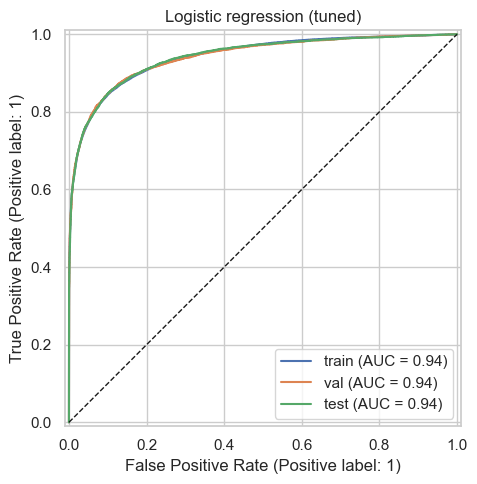

In [ ]:
log_reg_tunable = Pipeline(
    steps=[
        ("preprocess", linear_preprocess),
        (
            "clf",
            LogisticRegression(
                max_iter=800,
                n_jobs=-1,
                solver="saga",
                penalty="l2",
                class_weight="balanced",
            ),
        ),
    ]
)

search_space = {
    "clf__penalty": ["l1", "l2"],
    "clf__C": loguniform(1e-3, 1e2),
    "clf__class_weight": ["balanced", None],
}

log_reg_search = RandomizedSearchCV(
    estimator=log_reg_tunable,
    param_distributions=search_space,
    n_iter=12,
    scoring="roc_auc",
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1,
    verbose=1,
    refit=True,
    random_state=RANDOM_STATE,
)

log_reg_search.fit(X_train, y_train)
print("Best params:", log_reg_search.best_params_)
log_tuned_metrics = evaluate_pipeline(
    log_reg_search.best_estimator_,
    {
        "train": (X_train, y_train),
        "val": (X_val, y_val),
        "test": (X_test, y_test),
    },
)
print(log_tuned_metrics)
plot_roc_curves(
    log_reg_search.best_estimator_,
    {"train": (X_train, y_train), "val": (X_val, y_val), "test": (X_test, y_test)},
    title="Logistic regression (tuned)",
)


In [12]:
best_log_model = log_reg_search.best_estimator_
preprocessor = best_log_model.named_steps["preprocess"]

try:
    feature_names = preprocessor.get_feature_names_out()
except Exception:
    feature_names = get_feature_names(preprocessor, categorical_cols, numeric_cols)

coef = best_log_model.named_steps["clf"].coef_.ravel()
print(f"feature_names: {len(feature_names)}, coefficients: {len(coef)}")

if len(feature_names) != len(coef):
    min_len = min(len(feature_names), len(coef))
    print(f"Warning: length mismatch, trimming to {min_len} to align.")
    feature_names = feature_names[:min_len]
    coef = coef[:min_len]

coef_df = pd.DataFrame({"feature": feature_names, "coef": coef})
coef_df["abs_coef"] = coef_df["coef"].abs()
print("Top weighted features (|coef|):")
display(coef_df.sort_values("abs_coef", ascending=False).head(25))


feature_names: 28, coefficients: 28
Top weighted features (|coef|):


,feature,coef,abs_coef
27,cat__x26_PT,-1.755713,1.755713
7,num__x14,1.384898,1.384898
24,cat__x25_D_C,-1.352559,1.352559
26,cat__x26_Bt,1.145633,1.145633
25,cat__x25_L_C,0.742481,0.742481
2,num__x9,0.433588,0.433588
13,num__x20,0.376488,0.376488
11,num__x18,0.367879,0.367879
10,num__x17,0.357810,0.357810
18,num__x28,-0.337922,0.337922


{'train': 0.9977897448480398, 'val': 0.9945228713367225, 'test': 0.995165851430462}


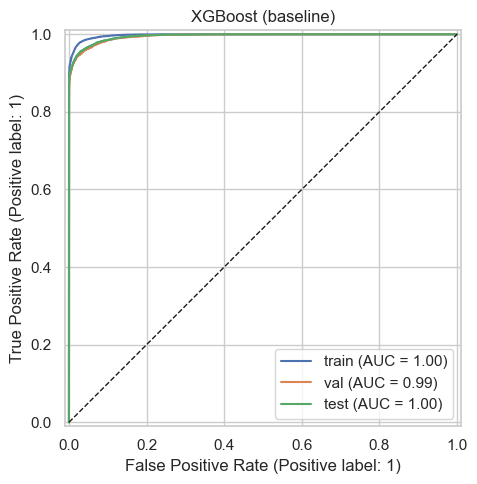

In [13]:
xgb_baseline = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=RANDOM_STATE,
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
)

xgb_pipe = Pipeline(
    steps=[
        ("preprocess", tree_preprocess),
        ("clf", xgb_baseline),
    ]
)

xgb_pipe.fit(X_train, y_train)

xgb_baseline_metrics = evaluate_pipeline(
    xgb_pipe,
    {
        "train": (X_train, y_train),
        "val": (X_val, y_val),
        "test": (X_test, y_test),
    },
)
print(xgb_baseline_metrics)
plot_roc_curves(
    xgb_pipe,
    {"train": (X_train, y_train), "val": (X_val, y_val), "test": (X_test, y_test)},
    title="XGBoost (baseline)",
)


In [14]:
xgb_search_space = {
    "clf__n_estimators": [200, 400, 600],
    "clf__max_depth": [4, 6, 8],
    "clf__learning_rate": loguniform(0.01, 0.3),
    "clf__subsample": [0.7, 0.85, 1.0],
    "clf__colsample_bytree": [0.7, 0.85, 1.0],
    "clf__min_child_weight": [1.0, 2.0, 4.0],
    "clf__reg_lambda": [0.5, 1.0, 2.0],
}

xgb_search = RandomizedSearchCV(
    estimator=Pipeline(
        steps=[
            (
                "preprocess",
                make_preprocessor(categorical_cols, numeric_cols, scale_numeric=False),
            ),
            (
                "clf",
                XGBClassifier(
                    objective="binary:logistic",
                    eval_metric="auc",
                    tree_method="hist",
                    random_state=RANDOM_STATE,
                ),
            ),
        ]
    ),
    param_distributions=xgb_search_space,
    n_iter=8,
    scoring="roc_auc",
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1,
    verbose=1,
    refit=True,
    random_state=RANDOM_STATE,
)


xgb_search.fit(X_train, y_train)
print("Best params:", xgb_search.best_params_)
xgb_tuned_metrics = evaluate_pipeline(
    xgb_search.best_estimator_,
    {"train": (X_train, y_train), "val": (X_val, y_val), "test": (X_test, y_test)},
)
print(xgb_tuned_metrics)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


/Users/qianchenyu/miniconda3/envs/urbanai/lib/python3.11/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['x29']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/qianchenyu/miniconda3/envs/urbanai/lib/python3.11/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['x29']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/qianchenyu/miniconda3/envs/urbanai/lib/python3.11/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['x29']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/qianchenyu/miniconda3/envs/urbanai/lib/python3.11/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['x29']. At least one non-missing value is

Best params: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.1501725572054684, 'clf__max_depth': 8, 'clf__min_child_weight': 4.0, 'clf__n_estimators': 200, 'clf__reg_lambda': 0.5, 'clf__subsample': 1.0}
{'train': 0.9996394669366754, 'val': 0.9945409347778511, 'test': 0.995339850576427}


Early stopping not supported in this xgboost version; training without it.
[0]	validation_0-auc:0.95711
[100]	validation_0-auc:0.98977
[200]	validation_0-auc:0.99193
[300]	validation_0-auc:0.99323
[400]	validation_0-auc:0.99397
[500]	validation_0-auc:0.99431
[600]	validation_0-auc:0.99447
[700]	validation_0-auc:0.99455
[800]	validation_0-auc:0.99461
[900]	validation_0-auc:0.99464
[1000]	validation_0-auc:0.99470
[1100]	validation_0-auc:0.99469
[1199]	validation_0-auc:0.99468
{'train': 0.9991228240135412, 'val': 0.9946828576665891, 'test': 0.9953952187988031}


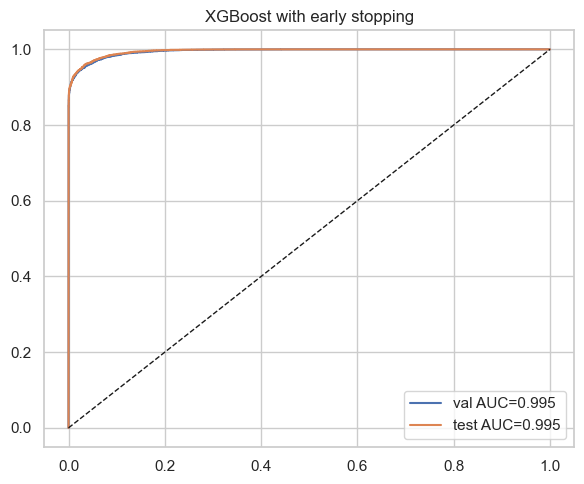

In [15]:


import inspect
from xgboost.callback import EarlyStopping

# Build preprocessing for trees

tree_preprocess_es = make_preprocessor(categorical_cols, numeric_cols, scale_numeric=False)
tree_preprocess_es.fit(X_train)
X_train_tree = tree_preprocess_es.transform(X_train)
X_val_tree = tree_preprocess_es.transform(X_val)
X_test_tree = tree_preprocess_es.transform(X_test)

scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

xgb_es = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=RANDOM_STATE,
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=2.0,
    reg_lambda=1.0,
    reg_alpha=0.0,
    scale_pos_weight=scale_pos_weight,
)

fit_kwargs = {
    "eval_set": [(X_val_tree, y_val)],
    "verbose": 100,
}

sig = inspect.signature(xgb_es.fit)
if "callbacks" in sig.parameters:
    fit_kwargs["callbacks"] = [EarlyStopping(rounds=50, save_best=True, metric_name="auc")]
elif "early_stopping_rounds" in sig.parameters:
    fit_kwargs["early_stopping_rounds"] = 50
else:
    print("Early stopping not supported in this xgboost version; training without it.")

xgb_es.fit(X_train_tree, y_train, **fit_kwargs)

def auc_on_arrays(model, X, y):
    return roc_auc_score(y, model.predict_proba(X)[:, 1])

xgb_es_metrics = {
    "train": auc_on_arrays(xgb_es, X_train_tree, y_train),
    "val": auc_on_arrays(xgb_es, X_val_tree, y_val),
    "test": auc_on_arrays(xgb_es, X_test_tree, y_test),
}
print(xgb_es_metrics)

fig, ax = plt.subplots(figsize=(6, 5))
for name, (X_split, y_split) in {
    "val": (X_val_tree, y_val),
    "test": (X_test_tree, y_test),
}.items():
    fpr, tpr, _ = roc_curve(y_split, xgb_es.predict_proba(X_split)[:, 1])
    label_text = f"{name} AUC={roc_auc_score(y_split, xgb_es.predict_proba(X_split)[:, 1]):.3f}"
    ax.plot(fpr, tpr, label=label_text)
ax.plot([0, 1], [0, 1], "k--", linewidth=1)
ax.set_title("XGBoost with early stopping")
ax.legend()
plt.tight_layout()


In [16]:
best_log_model = log_reg_search.best_estimator_
preprocessor = best_log_model.named_steps["preprocess"]

try:
    feature_names = preprocessor.get_feature_names_out()
except Exception:
    feature_names = get_feature_names(preprocessor, categorical_cols, numeric_cols)

coef = best_log_model.named_steps["clf"].coef_.ravel()
print(f"feature_names: {len(feature_names)}, coefficients: {len(coef)}")

if len(feature_names) != len(coef):
    min_len = min(len(feature_names), len(coef))
    print(f"Warning: length mismatch, trimming to {min_len} to align.")
    feature_names = feature_names[:min_len]
    coef = coef[:min_len]

coef_df = pd.DataFrame({"feature": feature_names, "coef": coef})
coef_df["abs_coef"] = coef_df["coef"].abs()
print("Top weighted features (|coef|):")
display(coef_df.sort_values("abs_coef", ascending=False).head(25))


feature_names: 28, coefficients: 28
Top weighted features (|coef|):


,feature,coef,abs_coef
27,cat__x26_PT,-1.755713,1.755713
7,num__x14,1.384898,1.384898
24,cat__x25_D_C,-1.352559,1.352559
26,cat__x26_Bt,1.145633,1.145633
25,cat__x25_L_C,0.742481,0.742481
2,num__x9,0.433588,0.433588
13,num__x20,0.376488,0.376488
11,num__x18,0.367879,0.367879
10,num__x17,0.357810,0.357810
18,num__x28,-0.337922,0.337922


In [17]:
xgb_feat_names = tree_preprocess_es.get_feature_names_out()
xgb_importance = pd.Series(xgb_es.feature_importances_, index=xgb_feat_names)
print("Top tree-based importances:")
display(xgb_importance.sort_values(ascending=False).head(25))


Top tree-based importances:


num__x14          0.281517
cat__x26_PT       0.133489
cat__x26_Bt       0.098279
num__x9           0.090862
num__x28          0.063373
cat__x25_L_C      0.056452
cat__x25_D_C      0.054876
num__x16          0.036627
num__x20          0.023585
num__x15          0.020325
num__x22          0.016805
num__x19          0.016240
num__x21          0.014778
num__x18          0.013299
num__x11          0.012768
num__x12          0.011721
num__x17          0.010964
num__x10          0.006555
num__x5           0.006130
num__x6           0.005836
num__x24          0.005694
cat__x3_Female    0.004005
num__x13          0.003962
num__x31          0.003196
num__x23          0.003084
dtype: float32

In [18]:
from sklearn.metrics import roc_auc_score
import pandas as pd


log_model = log_reg_search.best_estimator_        # Logistic
xgb_model = xgb_es                                 #XGBoost


log_aucs = {
    "train": roc_auc_score(y_train, log_model.predict_proba(X_train)[:, 1]),
    "val":   roc_auc_score(y_val,   log_model.predict_proba(X_val)[:, 1]),
    "test":  roc_auc_score(y_test,  log_model.predict_proba(X_test)[:, 1]),
}

xgb_aucs = {
    "train": roc_auc_score(y_train, xgb_model.predict_proba(X_train_tree)[:, 1]),
    "val":   roc_auc_score(y_val,   xgb_model.predict_proba(X_val_tree)[:, 1]),
    "test":  roc_auc_score(y_test,  xgb_model.predict_proba(X_test_tree)[:, 1]),
}

table = pd.DataFrame(
    {
        "Metric": ["AUC for training", "*AUC for validation", "AUC for testing"],
        "Model1 - logistic regression": [
            log_aucs["train"], log_aucs["val"], log_aucs["test"]
        ],
        "Model2 - non-logistic (XGBoost)": [
            xgb_aucs["train"], xgb_aucs["val"], xgb_aucs["test"]
        ],
    }
).set_index("Metric")

display(table.style.format("{:.4f}"))


,Model1 - logistic regression,Model2 - non-logistic (XGBoost)
Metric,,
AUC for training,0.9422,0.9991
*AUC for validation,0.9417,0.9947
AUC for testing,0.9425,0.9954
